For 2 weeks I worked hard and didn't improve my score. For 4 days I worked smart, and got LB 0.920 (74th out of 9000+). 

The main purpose of this kernel is to share the thinking process that led me to this LB score, at the same time that you can have fun visualizing the data.


### **1. INTRODUCTION**

In this competition, the objective was to forecast which clients would make a specific transfer in the future. The data given was composed of 200.000 rows and 200 anonymized features.

The evaluation metric was ROC-AUC. In case you are not familliar with it, check it [here](https://medium.com/greyatom/lets-learn-about-auc-roc-curve-4a94b4d88152).

**Context**:
This competition broke Kaggle's previous competitors record (around 6000), and became the most disputed competition ever in this platform, with over 9000 competitors. For many weeks, almost no team could surpass the 0.901 score barrier. So everyone started to look for the "magic".

### **2. WHAT DIDN'T WORK**

Many teams tried to explore the data in every possible way: Features operations (+,-,*,/,log,tanh,etc), distribution, probability, time series, target encoding, data rotation, genetic programming, oversampling, undersampling, different models....you get it. Absolutely nothing worked

After 2 weeks trying everything, I got tired of working hard and decided to work smart, so this happened: I broke the 0.901 barrier.

![](https://raw.githubusercontent.com/fmellomascarenhas/Kaggle/master/Santander%20-%202019%20-%2074th%20place/pictures/0.902_score.png)

### **3. WHAT WORKED**

**WARNING:** Before you proceed, you should know that **the scores you will see won't match the ones described**. That's because I used a simple train_test_split to speed up this kernel, instead of kfolds.

### **3.1. CV 0.902 - MAGIC IN 4 LINES**

When I decided to work smart, I re-read relevant topics and kernels in this competition and made a list about the dos and donts expressed by other competitors (as you can see below). [Making a kernel](https://www.kaggle.com/felipemello/why-your-model-is-overfitting-not-making-progress) about my own failed experiments helped me realize why they were not working.

**At this point, what did I know?**

1) Regular transformations wouldn't work (many topics shared failed experiments). 

2) [The test dataset had fake data](https://www.kaggle.com/yag320/list-of-fake-samples-and-public-private-lb-split), and that was relevant.

![](https://raw.githubusercontent.com/fmellomascarenhas/Kaggle/master/Santander%20-%202019%20-%2074th%20place/pictures/kernel_comment_1.png)

3) That [unique values](https://www.kaggle.com/triplex/more-unique-values-in-train-set-than-test-set) were, somehow, important.

![](https://raw.githubusercontent.com/fmellomascarenhas/Kaggle/master/Santander%20-%202019%20-%2074th%20place/pictures/kernel_comment_2.png)

So I decided to experiment with both of these ideas: I merged the train and test datataset without fake values, created new columns for each variable with the number of unique values in it, and trained my model. That was enough to break the 0.901. You can see this simples procedure below.


In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt


train_df = pd.read_csv('../input/santander-customer-transaction-prediction/train.csv')
test_df = pd.read_csv('../input/santander-customer-transaction-prediction/test.csv') 

#1 set of fake data and 2 sets of true data, as mentioned above.
synthetic_samples_indexes = np.load('synthetic_samples_indexes.npy')
private_LB = np.load('private_LB.npy')
public_LB = np.load('public_LB.npy')

#Merge the train_df with the test_df true data
full = pd.concat([train_df, pd.concat([test_df.loc[private_LB], test_df.loc[public_LB]], sort = False)], sort = False)

#Created new columns with the unique values count
for feat in ['var_' + str(x) for x in range(200)]:
    count_values = full.groupby(feat)[feat].count()
    train_df['new_' + feat] = count_values.loc[train_df[feat]].values
    test_df['new_' + feat] = count_values.loc[test_df[feat]].values

print('full_df has {} rows and {} columns'.format(full.shape[0], full.shape[1]))

#trained the model with LGB and submited.


full_df has 300000 rows and 202 columns


### **3.2. CV 0.909 - SETTING FEATURE FRACTION TO 1**

Feature fraction is a [parameter of the LGB model](https://lightgbm.readthedocs.io/en/latest/Parameters.html). It goes from 0 to 1 and represents the percentage of the data that you will use on each iteration of the traning. My feature fraction was 0.3. When I set it to 1, the model was able to look at all the variables at once, and voilá: CV 0.909! 

**TIP**: Setting feature fraction to 1 is a great way to understand the impact of a new feature in your model.

![](https://raw.githubusercontent.com/fmellomascarenhas/Kaggle/master/Santander%20-%202019%20-%2074th%20place/pictures/909_score.png)


### **3.3. CV 0.913 - MAKING MY JOB EASIER**

At this point, I had a problem to solve: Each new feature about values frequency only mattered for one other specific feature. My model, however, was checking all possible interactions between my 400 features and taking a **long time to run**. 

This [kernel](https://www.kaggle.com/ymatioun/santander-model-one-feature-at-a-time) was the perfect solution, when it proved that it was possible to train the model on each one of the variables separately and still achieve the same LB score. 

So I decided train my model with 2 features at a time: The original one and an extra column with the unique values count.

**RESULT: Less than 2 minutes to train my whole model (as opposed to over an hour) and CV of 0.913. Working smart was the way to go.**

In [4]:
from sklearn.model_selection import train_test_split
seed = 2319
param = {
    'num_leaves': 8,
    'min_data_in_leaf': 17,
    'learning_rate': 0.01,
    'min_sum_hessian_in_leaf': 9.67,
    'bagging_fraction': 0.8329,
    'bagging_freq': 2,
    'feature_fraction': 1,
    'lambda_l1': 0.6426,
    'lambda_l2': 0.3067,
    'min_gain_to_split': 0.02832,
    'max_depth': -1,
    'seed': seed,
    'feature_fraction_seed': seed,
    'bagging_seed': seed,
    'drop_seed': seed,
    'data_random_seed': seed,
    'objective': 'binary',
    'boosting_type': 'gbdt',
    'verbosity': -1,
    'metric': 'auc',
    'is_unbalance': True,
    'save_binary': True, 
    'boost_from_average': 'false',   
    'num_threads': 8
}

features = [c for c in train_df.columns if (c not in ['ID_code', 'target'])]

test_size = 0.3
X_train, X_test, y_train, y_test = train_test_split(train_df[features], train_df['target'], test_size = test_size, random_state=42)

iterations = 110
y_hat = np.zeros([int(200000*test_size), 200])
#test_hat = np.zeros([200000, 200])
i = 0
for feature in ['var_' + str(x) for x in range(200)]: # loop over all features
    #print(feature)
    feat_choices = [feature, 'new_' + feature]
    lgb_train = lgb.Dataset(X_train[feat_choices], y_train)
    gbm = lgb.train(param, lgb_train, iterations, verbose_eval=-1)
    y_hat[:, i] = gbm.predict(X_test[feat_choices], num_iteration=gbm.best_iteration)
    #test_hat[:, i] = gbm.predict(test_df[feat_choices], num_iteration=gbm.best_iteration)
    i += 1
    
    
sub_preds = (y_hat).sum(axis=1)
score = roc_auc_score(y_test, sub_preds)
print('Your CV score is', score)

Your CV score is 0.9210110787331031


In [7]:
def sample_plot_feature(data, f_target, t_target, features, label1='0', label2='1', bins=10, 
                        color1='r', color2='g'):
    n_features = len(features) 
    if n_features > 5:
        rows = int(np.ceil(n_features / 5))
        cols = 5
    else:
        rows = 1
        cols = n_features        
    sns.set_style('darkgrid')
    i = 0
    plt.figure()
    fig, ax = plt.subplots(rows, cols, figsize=(16, 14))
    for f in features:
        i += 1
        plt.subplot(rows, cols, i)        
        sns.distplot(data[f_target][f], label=label1, kde=True, rug=False, hist=True, bins=bins, color=color1) 
        sns.distplot(data[t_target][f], label=label2, kde=True, rug=False, hist=True, bins=bins, color=color2) 
        plt.xlabel(f, fontsize=9)    
        plt.legend(labels=[label1, label2])
        locs, labels = plt.xticks()        
        plt.tick_params(axis='x', which='major', labelsize=6, pad=-5)
        plt.tick_params(axis='y', which='major', labelsize=10)
    plt.show()

In [10]:
target_0_idx = train_df.target == 0
target_1_idx = train_df.target == 1

<Figure size 432x288 with 0 Axes>

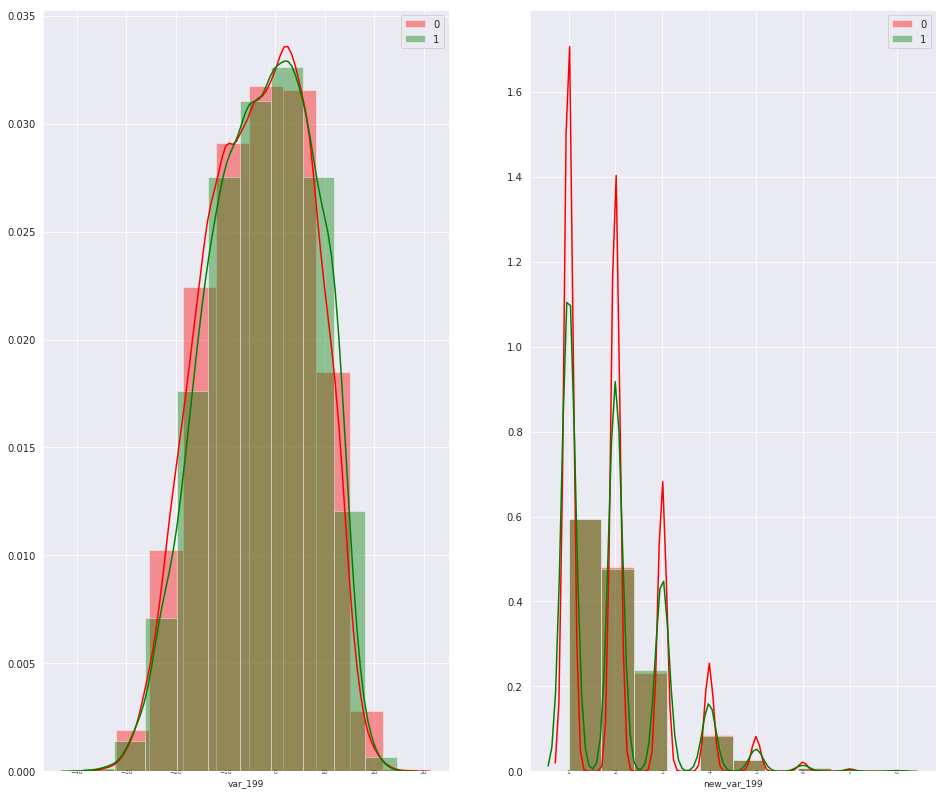

In [12]:
features_list = ['var_199', 'new_var_199']
sample_plot_feature(train_df, target_0_idx, target_1_idx, features_list)

In [17]:
common_cols = ['ID_code', 'target']
features_cols = [f for f in train_df.columns.tolist() if f not in common_cols]
target_col = ['target']

#### **3.4. OPTIMIZING PARAMETERS - CV 0.920**

Since my model now only took a couple of minutes to train, it became really easy to test hundreds of parameters. You can check a great kernel about Bayesian Optimization [here](https://www.kaggle.com/fayzur/lgb-bayesian-parameters-finding-rank-average).

![](https://raw.githubusercontent.com/fmfn/BayesianOptimization/master/examples/func.png)

Just leaving the algorithm working there for 3 hours was enough to score 0.920LB on the last day of competition. If I had more hours to work with it, probably my score would have improved substantially.

**Tips:** The number of iterations on the LGB was found to be really important. You can't just leave a high number of iterations and set your model to do an early stop if the score doesn't improve.

![](https://raw.githubusercontent.com/fmellomascarenhas/Kaggle/master/Santander%20-%202019%20-%2074th%20place/pictures/920_score.png)

Those were my final parameters (click on the **code** button ->):

In [ ]:
iterations = 126
param = {'bagging_fraction': 0.7693,
   'bagging_freq': 2,
   'lambda_l1': 0.7199,
   'lambda_l2': 1.992,
   'learning_rate': 0.009455,
   'max_depth': 3,
   'min_data_in_leaf': 22,
   'min_gain_to_split': 0.06549,
   'min_sum_hessian_in_leaf': 18.55,
   'num_leaves': 20,
   'feature_fraction': 1,
   'save_binary': True,
   'seed': 2319,
   'feature_fraction_seed': 2319,
   'bagging_seed': 2319,
   'drop_seed': 2319,
   'data_random_seed': 2319,
   'objective': 'binary',
   'boosting_type': 'gbdt',
   'verbosity': -1,
   'metric': 'auc',
   'is_unbalance': True,
   'boost_from_average': 'false',
   'num_threads': 6}

#### **3.5. GIVING WEIGHTS TO EACH FEATURE'S RESULT - CV 0.922**

Since we were training the model on each feature, maybe one matered more than other, but how could our model find it? To solve that, before we calculated the AUC score, we decided to give to each column a weight, based on their individual AUC score. That raised my score in 0.002.

In [ ]:
iterations = 126
param = {'bagging_fraction': 0.7693,
   'bagging_freq': 2,
   'lambda_l1': 0.7199,
   'lambda_l2': 1.992,
   'learning_rate': 0.009455,
   'max_depth': 3,
   'min_data_in_leaf': 22,
   'min_gain_to_split': 0.06549,
   'min_sum_hessian_in_leaf': 18.55,
   'num_leaves': 20,
   'feature_fraction': 1,
   'save_binary': True,
   'seed': 2319,
   'feature_fraction_seed': 2319,
   'bagging_seed': 2319,
   'drop_seed': 2319,
   'data_random_seed': 2319,
   'objective': 'binary',
   'boosting_type': 'gbdt',
   'verbosity': -1,
   'metric': 'auc',
   'is_unbalance': True,
   'boost_from_average': 'false',
   'num_threads': 6}

#------------------------- Trains the model ---------------------
features = [c for c in train_df.columns if (c not in ['ID_code', 'target'])]

test_size = 0.3
X_train, X_test, y_train, y_test = train_test_split(train_df[features], train_df['target'], test_size = test_size, random_state=42)

iterations = 110
y_hat = np.zeros([int(200000*test_size), 200])
#test_hat = np.zeros([200000, 200])
i = 0
for feature in ['var_' + str(x) for x in range(200)]: # loop over all features
    #print(feature)
    feat_choices = [feature, 'new_' + feature]
    lgb_train = lgb.Dataset(X_train[feat_choices], y_train)
    gbm = lgb.train(param, lgb_train, iterations, verbose_eval=-1)
    y_hat[:, i] = gbm.predict(X_test[feat_choices], num_iteration=gbm.best_iteration)
    #test_hat[:, i] = gbm.predict(test_df[feat_choices], num_iteration=gbm.best_iteration)
    i += 1


In [ ]:
#The trainning code is hidden above
#--------Calculate weights to give to each feature prediction---------
weights = []
for col in range(200):
    if roc_auc_score(y_test, y_hat[:,col]) >= 0.5:
        weights.append(roc_auc_score(y_test, y_hat[:,col]))
    else:
        weights.append(0)
        
weights = np.array(weights)
weights = (weights - weights.mean()) / weights.mean()
weights += 1

#--------Calculates AUC score------------
sub_preds_regular = (y_hat).sum(axis=1)
sub_preds_weighted = (y_hat*weights).sum(axis=1)
score_regular = roc_auc_score(y_test, sub_preds_regular)
score_weighted = roc_auc_score(y_test, sub_preds_weighted)

print('Your unweigthed score is:', score_regular)
print('Your weigthed score is:', score_weighted)

You could try to optimize those weights in some other way. A good option, for example, would be to use the bayesian optimizer.

If you want to use the weights, make sure that they are not overfitting your results. The best way is to use stratified k folds, and then apply the weights. Below is an example on how to test them before submiting.

In [ ]:
#Here I just defined where I would divide my y_test. This is not the optimal way to do it though.
#You should get samples randomly, and a good way to do that is using the train_test_split of sklearn
test_data_length = len(y_test)
validation_length = int(test_data_length/4)

#Calculates teh weights
weights = []
for col in range(200):
    if roc_auc_score(y_test[:validation_length], y_hat[:validation_length,col]) >= 0.5:
        weights.append(roc_auc_score(y_test[:validation_length], y_hat[:validation_length,col]))
    else:
        weights.append(0)
        
weights = np.array(weights)
weights = (weights - weights.mean()) / weights.mean()
weights += 1

#tests with and without weights     
sub_preds_regular = (y_hat[validation_length:]).sum(axis=1)
sub_preds_weighted = (y_hat[validation_length:]*weights).sum(axis=1)

score_regular = roc_auc_score(y_test[validation_length:], sub_preds_regular)
score_weighted = roc_auc_score(y_test[validation_length:], sub_preds_weighted)

print('Your unweigthed score is:', score_regular)
print('Your weigthed score is:', score_weighted)
if score_weighted > score_regular:
    print('Your weights ARE NOT overfitting')
else:
    print('Your weights ARE overfitting')

### **4. LOOKING AT THE DATA: WHAT IS ODD ABOUT THE UNIQUE VALUES?**

**EDIT: I didn't know that  bimodal distribution is a natural phenomena of normal distributions. Thanks @cdeotte and @triplex for pointing that out. I will still leave the plots there, because even though it is a natural phenomena, it is a cool one.**

When I looked at the Probability Density Functions (PDFs) of our variables, I discovered a clear bimodal distribution that exists among values that do not repeat. As those values start repeating more, the distribution changes, and it is really interesting to see.

To show that to you, first I will need to group some values.

### **4.1. GROUPING VALUES**

Some variables, like var_12 and var_68, have many frequency groups. Some of these groups are really small, and can have less than 100 samples. Take a look and compare the PDFs of frequency groups in var_12 and var_81:

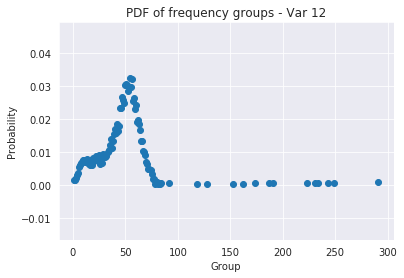

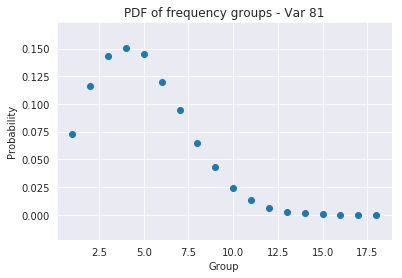

In [23]:
n = 12
var_68_values_frequency = train_df['new_var_' + str(n)]
n = 81
var_81_values_frequency = train_df['new_var_' + str(n)]

fig = plt.figure()
x_68 = var_68_values_frequency.value_counts().index
Y_68 = var_68_values_frequency.value_counts().values / sum(var_68_values_frequency.value_counts().values)
plt.scatter(x_68, Y_68)
plt.title('PDF of frequency groups - Var 12')
plt.xlabel('Group')
plt.ylabel('Probability')
plt.show()

fig = plt.figure()
x_81 = var_81_values_frequency.value_counts().index
Y_81 = var_81_values_frequency.value_counts().values / sum(var_81_values_frequency.value_counts().values)
plt.scatter(x_81, Y_81)
plt.title('PDF of frequency groups - Var 81')
plt.xlabel('Group')
plt.ylabel('Probability')
plt.show()

To avoid working with such small groups and risk overfitting, we will say that each group has to have at least 2000 samples in the test + train datasets in total.

In [24]:
pd.options.mode.chained_assignment = None #disables copying warning

#Example: If the group 1, with values that repeat only once, has less than 2000 samples,
#we will merge it with group 2, that has values that repeat twice, and extinguish group 1.
#If the new formed group 2 has less than 2000 samples, than we will merge it with group 3,
#and extinguish group 2, until they are in a group with 2000 samples.
    
#sets the minimum sample quantity per group
min_n_unique_full = 2000
min_n_unique_train = int(min_n_unique_full*2/3)
min_n_unique_test = int(min_n_unique_full*1/3)

#merge train and test df
full = pd.concat([train_df, pd.concat([test_df.loc[private_LB], test_df.loc[public_LB]], sort = False)], sort = False)
true_test_df = pd.concat([test_df.loc[private_LB], test_df.loc[public_LB]], sort = False)

count = 1

#Do the groupping process for every variable in the dataset
for feat in ['var_' + str(x) for x in range(200)]:

    if count%50 == 1:
        print('Processing reached', feat)
        
    n_unique_list_full = list(set(full['new_' + feat]))
 
    n_unique_list_full.sort()
    
    #Do it forward: Group 1 -> group 2 - > groups 3
    for i in range(len(n_unique_list_full)):
        n_unique_full = n_unique_list_full[i]
        
        len_n_unique_full = len(full[feat][full['new_' + feat] == n_unique_full])
        len_n_unique_train = len(train_df[feat][train_df['new_' + feat] == n_unique_full])
        len_n_unique_test = len(true_test_df[feat][true_test_df['new_' + feat] == n_unique_full])
        
#        print(len_n_unique)

        if len_n_unique_full < min_n_unique_full or len_n_unique_train < min_n_unique_train or len_n_unique_test < min_n_unique_test :
            try:
                full['new_' + feat][full['new_' + feat] == n_unique_full] = n_unique_list_full[i+1]
                train_df['new_' + feat][train_df['new_' + feat] == n_unique_full] = n_unique_list_full[i+1]
                true_test_df['new_' + feat][true_test_df['new_' + feat] == n_unique_full] = n_unique_list_full[i+1]
                test_df['new_' + feat][test_df['new_' + feat] == n_unique_full] = n_unique_list_full[i+1]
            except:
                continue

    #Do it backwards, so small groups at the end can be merged with bigger groups before them
    #Groups n -> group n-1 -> group n-2
    for i in reversed(range(len(n_unique_list_full))):
        n_unique_full = n_unique_list_full[i]
      
        len_n_unique_full = len(full[feat][full['new_' + feat] == n_unique_full])
        len_n_unique_train = len(train_df[feat][train_df['new_' + feat] == n_unique_full])
        len_n_unique_test = len(true_test_df[feat][true_test_df['new_' + feat] == n_unique_full])
        
#        print(len_n_unique)

        if len_n_unique_full < min_n_unique_full or len_n_unique_train < min_n_unique_train or len_n_unique_test < min_n_unique_test :
            try:
                full['new_' + feat][full['new_' + feat] == n_unique_full] = n_unique_list_full[i-1]
                train_df['new_' + feat][train_df['new_' + feat] == n_unique_full] = n_unique_list_full[i-1]
                true_test_df['new_' + feat][true_test_df['new_' + feat] == n_unique_full] = n_unique_list_full[i-1]
                test_df['new_' + feat][test_df['new_' + feat] == n_unique_full] = n_unique_list_full[i-1]
            except:
                continue
    
    count+=1 
print('Done!')

Processing reached var_0
Processing reached var_50
Processing reached var_100
Processing reached var_150
Done!


### **4.2. BIMODAL DISTRIBUTIONS**.

Now that we are done with grouping, check the bimodals distributions below. They show the PDFs of the 6 first frequency groups of each variable. Example: Graph 1: All values that are unique / Graph 2: All values that repeat only twitce / Graph 3: .... / etc.

Variable var_2


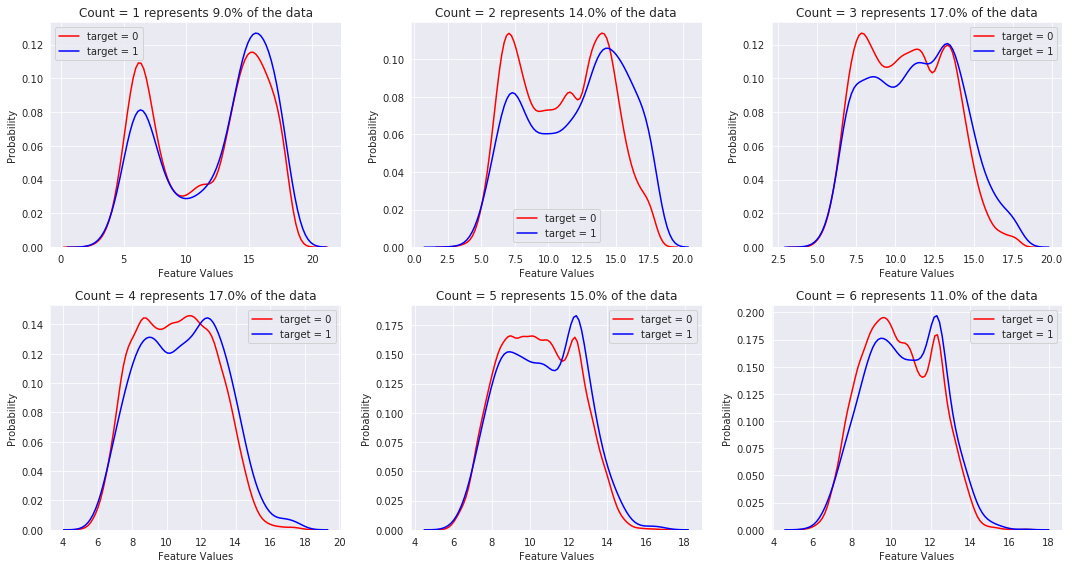

Variable var_53


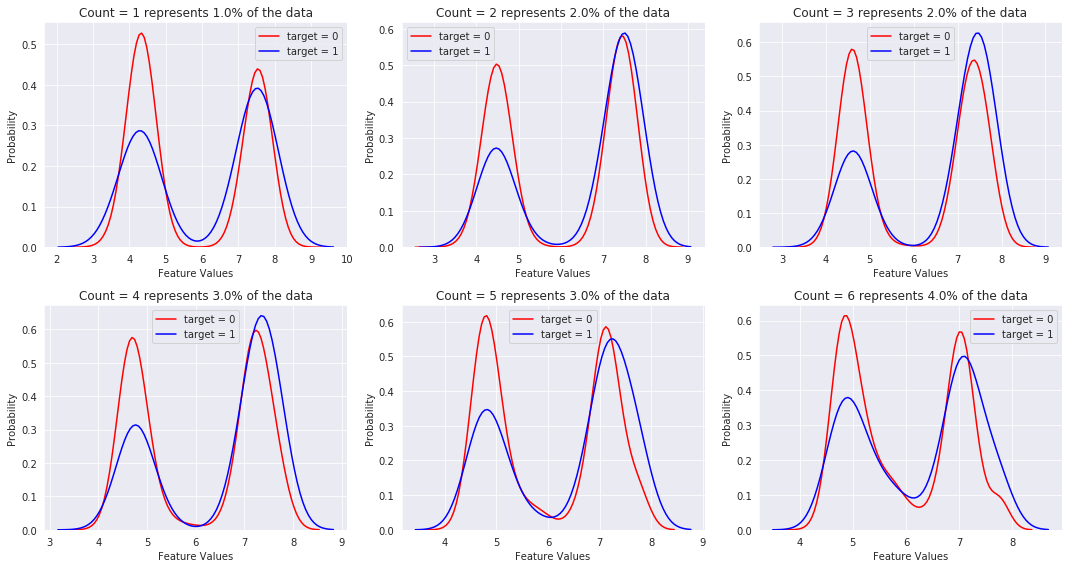

Variable var_81


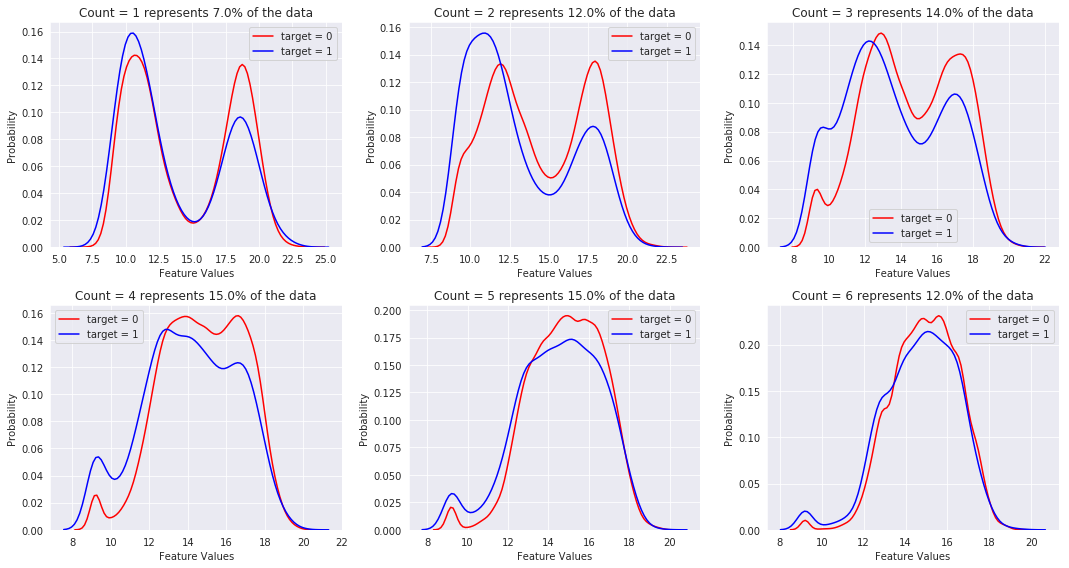

Variable var_111


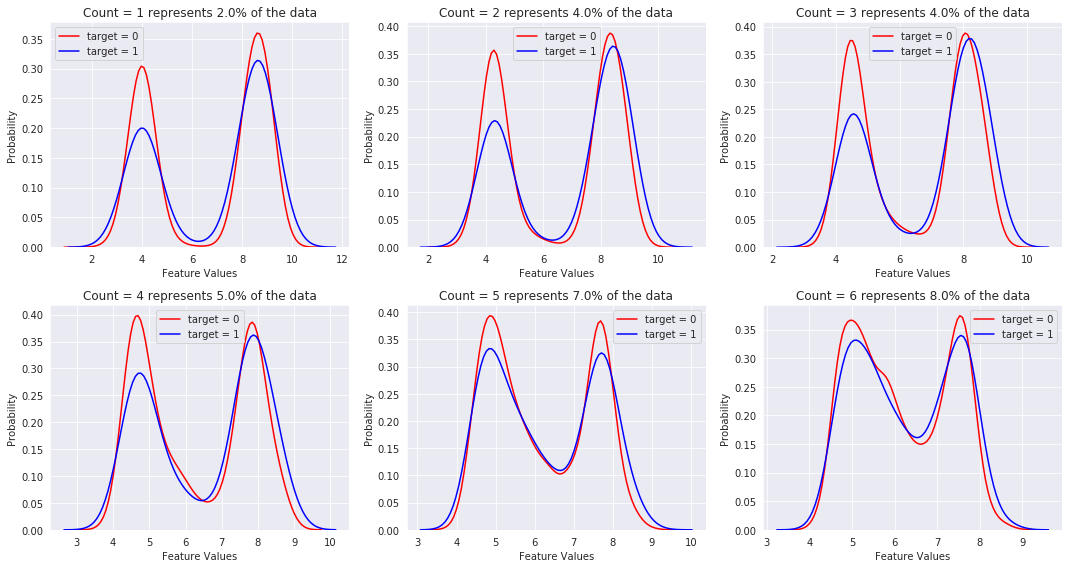

Variable var_121


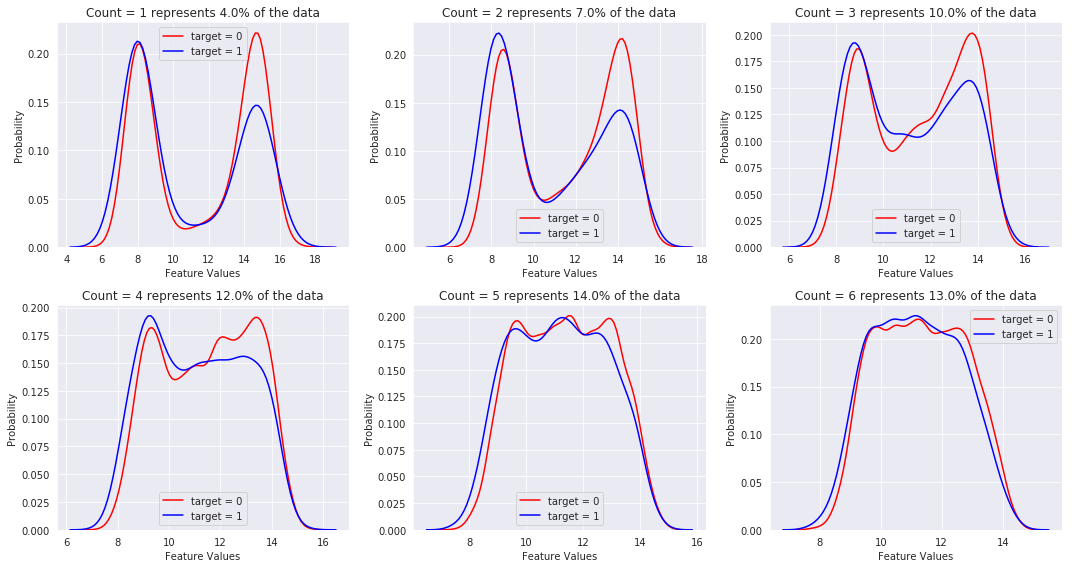

Variable var_126


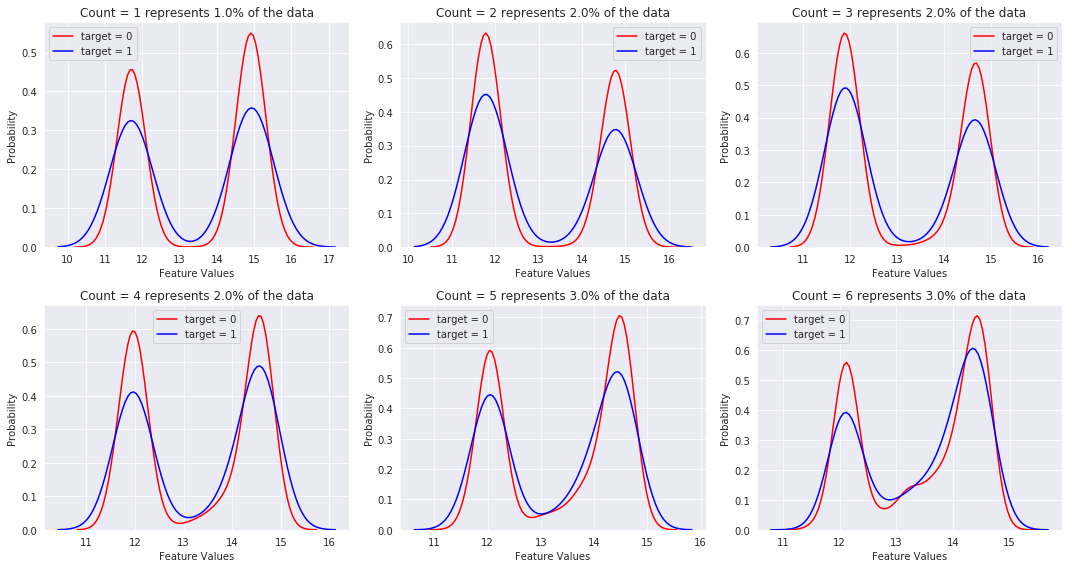

Variable var_130


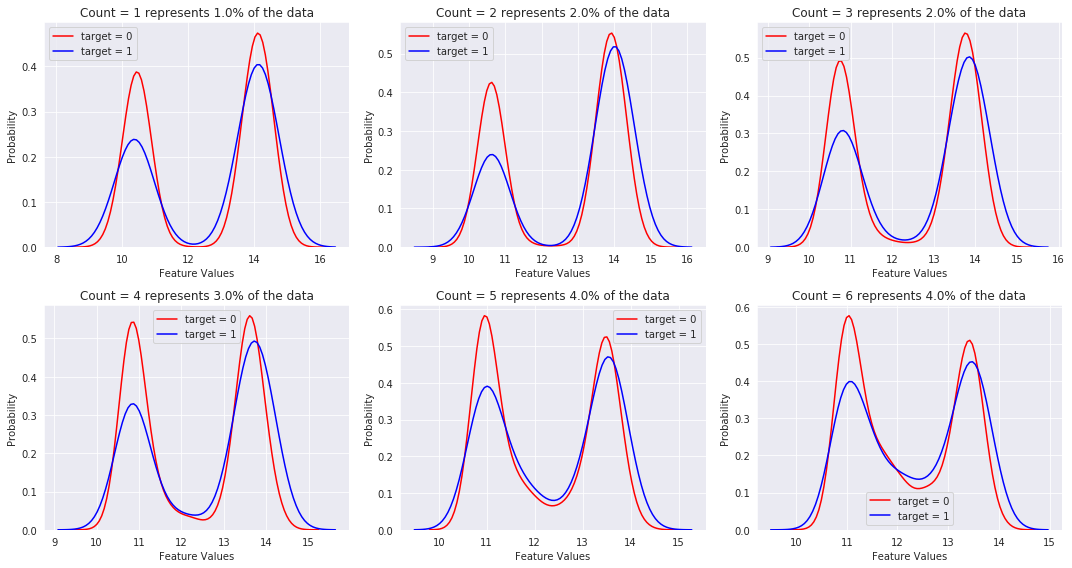

Variable var_146


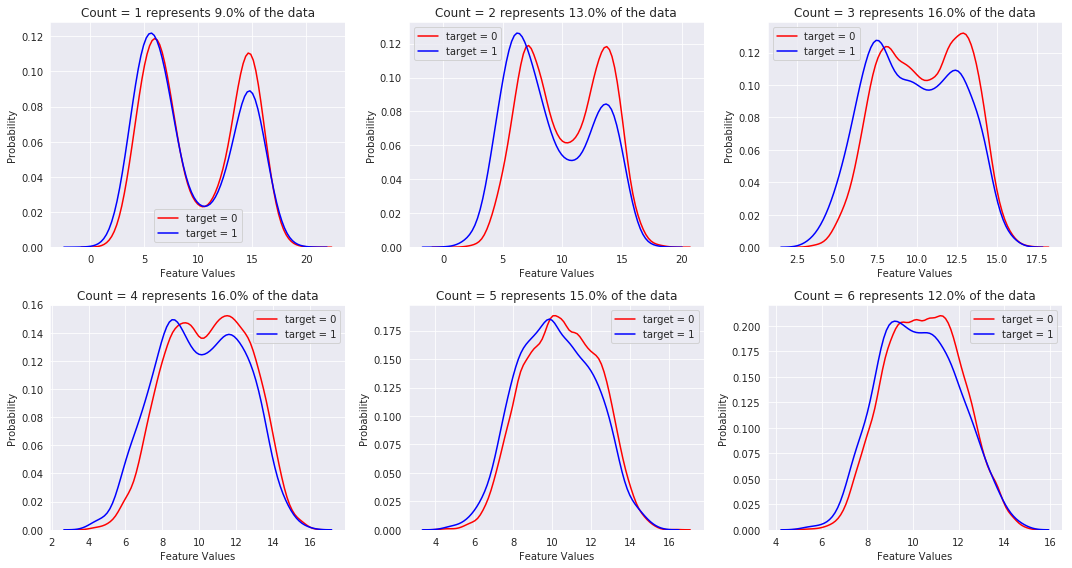

In [25]:
for n in [2, 53, 81, 111, 121, 126, 130, 146]:
    
    print('Variable', 'var_' + str(n))

    plt.figure(figsize=(15,8))

    count = 1

    for n_unique in list(set(train_df['new_var_' + str(n)]))[:6]:

        var_tar_0 = train_df['var_' + str(n)][(train_df['new_var_' + str(n)] == n_unique) &
                                              (train_df['target'] == 0)]
        var_tar_1 = train_df['var_' + str(n)][(train_df['new_var_' + str(n)] == n_unique) &
                                              (train_df['target'] == 1)]

        var_tar_0
        samples_0 = len(var_tar_0)
        samples_1 = len(var_tar_1)
        
        if samples_0 < 20 or samples_1 < 20:
            continue
            
        samples_percentage = np.round((samples_0 + samples_1)*100/ 200000)
        plt.subplot(2, 3, count)
        sns.kdeplot(var_tar_0, shade=False, color="red", label = 'target = 0')
        sns.kdeplot(var_tar_1, shade=False, color="blue", label = 'target = 1')

        plt.title('Count = {} represents {}% of the data'.format(n_unique, samples_percentage))
        plt.xlabel('Feature Values')
        plt.ylabel('Probability')
        count += 1

    plt.tight_layout()
    plt.show()
    

Not all features are like that though. Take a look at the feature 117 and 120.

Variable var_117


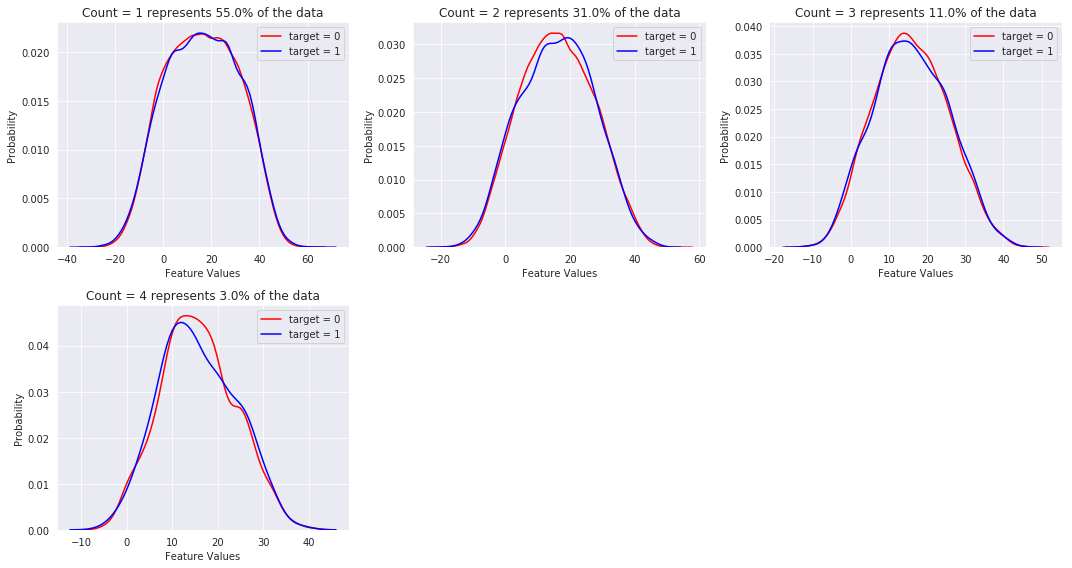

Variable var_120


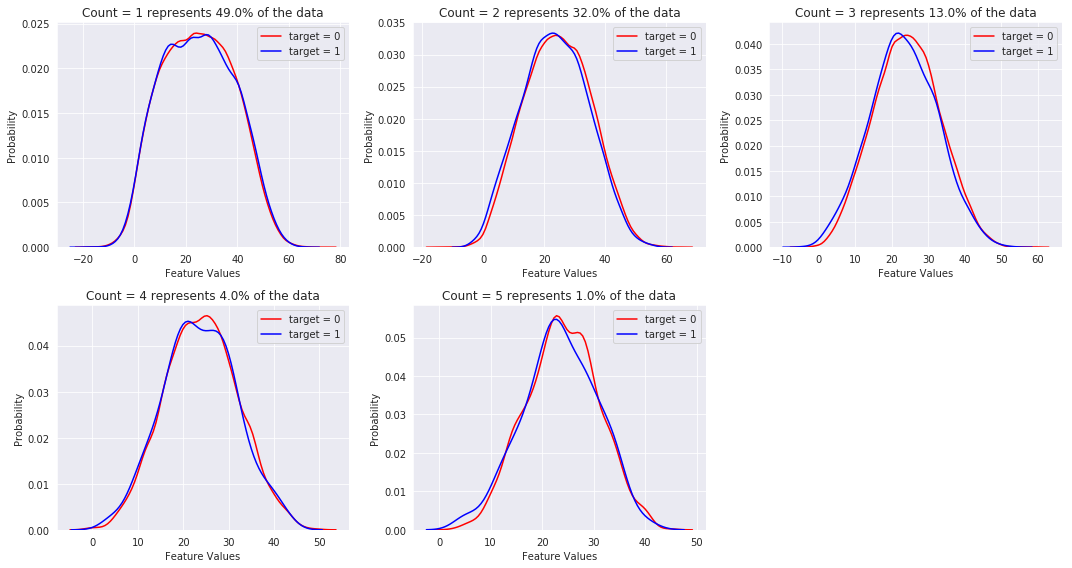

In [26]:
for n in [117, 120]:
    
    print('Variable', 'var_' + str(n))

    plt.figure(figsize=(15,8))

    count = 1

    for n_unique in list(set(train_df['new_var_' + str(n)]))[:6]:

        var_tar_0 = train_df['var_' + str(n)][(train_df['new_var_' + str(n)] == n_unique) &
                                              (train_df['target'] == 0)]
        var_tar_1 = train_df['var_' + str(n)][(train_df['new_var_' + str(n)] == n_unique) &
                                              (train_df['target'] == 1)]

        var_tar_0
        samples_0 = len(var_tar_0)
        samples_1 = len(var_tar_1)
        
        if samples_0 < 20 or samples_1 < 20:
            continue
            
        samples_percentage = np.round((samples_0 + samples_1)*100/ 200000)
        plt.subplot(2, 3, count)
        sns.kdeplot(var_tar_0, shade=False, color="red", label = 'target = 0')
        sns.kdeplot(var_tar_1, shade=False, color="blue", label = 'target = 1')

        plt.title('Count = {} represents {}% of the data'.format(n_unique, samples_percentage))
        plt.xlabel('Feature Values')
        plt.ylabel('Probability')
        count += 1

    plt.tight_layout()
    plt.show()

How cool is that? Couldn't figure out why this happens. If you have any hypothesis, let me know.

### **5. WHAT I WOULD LIKE TO HAVE DONE, IF I HAD MORE TIME**

#### **5.1. EXPLORE THE BIMODAL DISTRIBUTIONS**

Probabily trying to show to LGB that there is a bimodal distribution would be useless, because it already sees it. Take a look at the plot below of the variable 81.

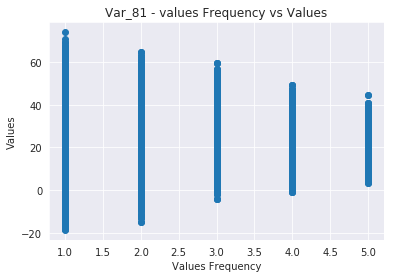

In [27]:
var_81_values = train_df['var_' + str(n)]

var_81_values_frequency = train_df['new_var_' + str(n)]

plt.figure()
plt.scatter(var_81_values_frequency, var_81_values)

plt.title('Var_81 - values Frequency vs Values')
plt.xlabel('Values Frequency')
plt.ylabel('Values')
plt.show()

For each one of the frequencys, the LGB is already going to make splits, figure out that there is a bimodal distribution and check the probabilities of being target = 1 or target = 0. If you are confused about it or if your don't believe me, check my kernel [Why your model is overfitting/not making progress](https://www.kaggle.com/felipemello/why-your-model-is-overfitting-not-making-progress)

**Besides that**, with a simple linear transformation, we could supperpose two distributions, making them more readable to our human eyes. Take a look at var_81 and var_126 before and after we transform var_126.

In [ ]:
#BEFORE TRANSFORMATION
n_unique = 1
n = 126
var_126_tar_0 = train_df['var_' + str(n)][(train_df['new_var_' + str(n)] == n_unique) &
                                              (train_df['target'] == 0)]
var_126_tar_1 = train_df['var_' + str(n)][(train_df['new_var_' + str(n)] == n_unique) &
                                      (train_df['target'] == 1)]

n = 81
var_81_tar_0 = train_df['var_' + str(n)][(train_df['new_var_' + str(n)] == n_unique) &
                                      (train_df['target'] == 0)]
var_81_tar_1 = train_df['var_' + str(n)][(train_df['new_var_' + str(n)] == n_unique) &
                                      (train_df['target'] == 1)]

fig = plt.subplots()
sns.kdeplot(var_126_tar_0, shade=False, color="r", label = 'var_126_tar_0')
sns.kdeplot(var_126_tar_1, shade=False, color="blue", label = 'var_126_tar_1')
sns.kdeplot(var_81_tar_0, shade=False, color="orange", label = 'var_81_tar_0')
sns.kdeplot(var_81_tar_1, shade=False, color="black", label = 'var_81_tar_1')
plt.title('PDFs of VAR 126 and 81 BEFORE transformation')
plt.xlabel('Feature Values')
plt.ylabel('Probability')
plt.show()

#AFTER TRANSFORMATION (just doing var_126 * 2.486 -18.5)
n_unique = 1
n = 126
var_126_tar_0 = train_df['var_' + str(n)][(train_df['new_var_' + str(n)] == n_unique) &
                                              (train_df['target'] == 0)] * 2.486 -18.5
var_126_tar_1 = train_df['var_' + str(n)][(train_df['new_var_' + str(n)] == n_unique) &
                                      (train_df['target'] == 1)] * 2.486 - 18.5

n = 81
var_81_tar_0 = train_df['var_' + str(n)][(train_df['new_var_' + str(n)] == n_unique) &
                                      (train_df['target'] == 0)]
var_81_tar_1 = train_df['var_' + str(n)][(train_df['new_var_' + str(n)] == n_unique) &
                                      (train_df['target'] == 1)]

fig = plt.subplots()
sns.kdeplot(var_126_tar_0, shade=False, color="r", label = 'var_126_tar_0')
sns.kdeplot(var_126_tar_1, shade=False, color="blue", label = 'var_126_tar_1')
sns.kdeplot(var_81_tar_0, shade=False, color="orange", label = 'var_81_tar_0')
sns.kdeplot(var_81_tar_1, shade=False, color="black", label = 'var_81_tar_1')
plt.title('PDFs of VAR 126 and 81 AFTER transformation')
plt.xlabel('Feature Values')
plt.ylabel('Probability')
plt.show()

Isn't this so interesting? But, again, scalling values won't affect the way that LGB sees the model. This transformation just makes it more pleasent to our eyes. 

**Note:** If you wanna do it yourself, just get the ratio of the distances between the peaks of the distributions, multiply one of the distributions by this ratio and subtract the differente between peaks of distribution 1 and 2.

#### **5.2. OPTIMIZE THE LGB PARAMETERS FOR EACH VARIABLE**

Since we have 200 different models, instead of having one set of parameters for all variables, we could pick  a specific set of parameters that works best for them.

I tried doing it, and saw my AUC falling back to 0.900. I am not sure why. Maybe its overfitting? I don't know if it is possible to do that, but if it is, I bet it could substantially increase the score.

#### **5.3. OTHER STUFF**

- Create NN to do ensembling;
- Try to use pure probability, instead of the LGB, as it was done in [this](https://www.kaggle.com/cdeotte/modified-naive-bayes-santander-0-899) kernel. Another competitor reported a 0.922 LB score using this technic and a gold medal;
- Applied augumentation, as described [here](https://www.kaggle.com/jiweiliu/lgb-2-leaves-augment).

However, there is only so much you can do in 4 days.


### 6. SUMMARY

Thank you for your attention. I hope you had fun. In this kernel we saw that:
- Smart work is better than hard work. It is faster and produces better results;
- If you think rationally about things, understand your model and your data, you can quickly improve your results;
- There is a lot more to explore in the data;

**If you liked the kernel, please, consider upvoting. It is the way to best reward the hours I put making this kernel. Thanks :)**

### MY FINAL RUN WITH 4 FOLDS

In [ ]:
param = {'bagging_fraction': 0.5166,
   'bagging_freq': 3,
   'lambda_l1': 3.968,
   'lambda_l2': 1.263,
   'learning_rate': 0.00141,
   'max_depth': 3,
   'min_data_in_leaf': 17,
   'min_gain_to_split': 0.2525,
   'min_sum_hessian_in_leaf': 19.55,
   'num_leaves': 20,
   'feature_fraction': 1,
   'save_binary': True,
   'seed': 2319,
   'feature_fraction_seed': 2319,
   'bagging_seed': 2319,
   'drop_seed': 2319,
   'data_random_seed': 2319,
   'objective': 'binary',
   'boosting_type': 'gbdt',
   'verbosity': -1,
   'metric': 'auc',
   'is_unbalance': True,
   'boost_from_average': 'false',
   'num_threads': 6}

#-------------Trains and predict-----------
folds = StratifiedKFold(n_splits=4, shuffle=False, random_state=2319)
target = train_df['target']
y_hat = np.zeros([200000, 200])
test_hat = np.zeros([200000, 200])
i = 0
for feature in ['var_' + str(x) for x in range(200)]: # loop over all features
    print(feature)
    feat_choices = [feature, 'new_' + feature]
    oof = np.zeros(len(train_df))
    predictions = np.zeros(len(test_df))
    for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_df[feat_choices].values, target.values)):
        #print("Fold :{}".format(fold_ + 1))
        trn_data = lgb.Dataset(train_df.iloc[trn_idx][feat_choices], label=target.iloc[trn_idx])
        val_data = lgb.Dataset(train_df.iloc[val_idx][feat_choices], label=target.iloc[val_idx])
        clf = lgb.train(param, trn_data, 126, valid_sets = [trn_data, val_data], verbose_eval=-1)
        oof[val_idx] = clf.predict(train_df.iloc[val_idx][feat_choices], num_iteration=clf.best_iteration)
        predictions += clf.predict(test_df[feat_choices], num_iteration=clf.best_iteration) / folds.n_splits
    print("CV score: {:<8.5f}".format(roc_auc_score(target, oof)))
    
    y_hat[:, i] = oof
    test_hat[:, i] = predictions
    i += 1

#--------------Calculate the weight importance of each feature----------
weights = []
for col in range(200):
    if roc_auc_score(target, y_hat[:,col]) >= 0.5:
        weights.append(roc_auc_score(target, y_hat[:,col]))
    else:
        weights.append(0)
        
weights = np.array(weights)
weights = (weights - weights.mean()) / weights.mean()
weights += 1


#-------------Get the test prediction-----------------------------
sub_preds = (y_hat*weights).sum(axis=1)/200
print('Your CV score is', roc_auc_score(target, sub_preds))

sub_preds_test = (test_hat*weights).sum(axis=1)/200
sub = pd.DataFrame({"ID_code": test_df.ID_code.values})
sub["target"] = sub_preds_test
sub.to_csv('submission.csv', index=False)